In [1]:
from llama_index.llms.mistralai import MistralAI
from llama_index.core.llms import ChatMessage
from mistralai import Mistral
import os

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
model = "mistral-large-latest"

client = Mistral(api_key=MISTRAL_API_KEY)

Intent detection

In [2]:
def detect_intent(user_input):
    response = client.classifiers.classify(
    model="ft:classifier:ministral-3b-latest:82f3f89c:20250422:agro-intent-clf:a0b2cfa8",
    inputs=[user_input],
    )
    scores = response.results[0]['intent'].scores
    predicted_label = max(scores, key=scores.get)

    return predicted_label

detect_intent("Comment savoir si mes tomates sont malades ?")

'disease_diagnosis'

Vector search

In [3]:
from utils import initialize_qdrant

qdrant_client = initialize_qdrant()

Loaded 143 document embeddings for technical_reports
Document embeddings loaded successfully


In [4]:
import numpy as np

def score_vector_search(query, collection_name="technical_reports"):
    query_embedding = client.embeddings.create(
        model="mistral-embed",
        inputs=[query],
    ).data[0].embedding

    response = qdrant_client.query_points(
        collection_name=collection_name,
        query=query_embedding,
        limit=30,
    )

    file_names = np.array([score.payload['file_name'].replace('.md', '') for score in response.points])
    scores_arr = np.array([score.score for score in response.points])

    unique_files = np.unique(file_names)
    scores_arr_norm = (scores_arr - np.nanmin(scores_arr)) / np.ptp(scores_arr) if np.ptp(scores_arr) > 0 else np.ones_like(scores_arr)

    max_scores_by_files = {str(file): scores_arr_norm[file_names == file].max() for file in unique_files}

    return max_scores_by_files

scores = score_vector_search("How do I know if my tomato is sick ?")
scores

{'2022_fiche-technique_environnement-2_nitrates': np.float64(0.0773110944521891),
 '2022_fiche-technique_presentation-generale': np.float64(0.6346333479492641),
 '2022_fiche-technique_sante-animaux-1_paquet-hygiene': np.float64(0.3223579544299179),
 '2022_fiche-technique_sante-animaux-3_ESST': np.float64(0.8302436619876772),
 '2022_fiche-technique_sante-animaux-4_identification': np.float64(0.11215354474649615),
 '2022_fiche-technique_sante-vegetaux-1_utilisation-PPP': np.float64(0.6059350915699976),
 '2022_fiche-technique_sante-vegetaux-2_paquet-hygiene': np.float64(0.6323755517108296),
 '2023_fiche-technique_BCAE7_rotation': np.float64(0.31559578167411906),
 '2023_fiche-technique_presentation-generale': np.float64(0.49884072436573423),
 '2023_fiche-technique_sante-vegetaux-1_utilisation-PPP': np.float64(0.9790109814903912),
 '2023_fiche-technique_sante-vegetaux-2_paquet-hygiene': np.float64(1.0),
 '2024_fiche-technique_BCAE7_rotation': np.float64(0.4036733569735661),
 '2024_fiche-tec

BM25 search

In [5]:
from utils import initialize_bm25

bm25 = initialize_bm25()

[nltk_data] Downloading package punkt to /home/estienne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
import nltk
import os

file_names = os.listdir("../../data/txt/technical_reports")

def score_bm25(query, top_k=30):
    tokenized_query = nltk.word_tokenize(query.lower())
    scores = bm25.get_scores(tokenized_query)

    scores_dict = dict(zip(file_names, scores))
    top_files = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    scores = np.array([score for _, score in top_files])

    bm25_norm = (scores - np.nanmin(scores)) / np.ptp(scores)
    norm_scores_dict = dict(zip([file.replace('.txt', '') for file, _ in top_files], bm25_norm))
    
    return norm_scores_dict

score_bm25("How do I know if my tomato is sick ?")

{'2022_fiche-technique_environnement-1_oiseaux-sauvages-habitats': np.float64(1.0),
 '2024_fiche-technique_BCAE8_biodiversite': np.float64(0.9099175712690547),
 '2022_fiche-technique_presentation-generale': np.float64(0.8473319764353349),
 '2022_fiche-technique_environnement-2_nitrates': np.float64(0.8424240240181591),
 '2022_fiche-technique_BCAE1_bande-tampon': np.float64(0.8341761022982922),
 '2024_fiche-technique_environnement-2_nitrates': np.float64(0.8197831308667083),
 '2022_fiche-technique_sante-animaux-1_paquet-hygiene': np.float64(0.801946336433694),
 '2023_fiche-technique_BCAE1_maintien-prairies-permanentes': np.float64(0.7814109494570135),
 '2024_fiche-technique_environnement-3_oiseaux_sauvages-habitats': np.float64(0.7808655207518197),
 '2023_fiche-technique_sante-vegetaux-1_utilisation-PPP': np.float64(0.7802726174229754),
 '2023_fiche-technique_BCAE8_biodiversite': np.float64(0.7652721395275097),
 '2024_fiche-technique_presentation-generale': np.float64(0.6380179581532436

Fusion document ranking

In [7]:
def score_fusion(query,top_k=5):
    vector_scores = score_vector_search(query)
    bm25_scores = score_bm25(query)

    all_files = set(vector_scores.keys()).union(set(bm25_scores.keys()))
    fusion_scores = {file: (vector_scores.get(file, 0) + bm25_scores.get(file, 0)) / 2 for file in all_files}

    top_files = sorted(fusion_scores.items(), key=lambda x: x[-1], reverse=True)[:top_k]
    top_files_dict = {file + ".md": score for file, score in top_files}
    return top_files_dict

score_fusion("Quelle est la législation sur les OGM ?")

{'2023_fiche-technique_sante-vegetaux-2_paquet-hygiene.md': np.float64(0.76630437896629),
 '2022_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.7552018219241939),
 '2022_fiche-technique_sante-vegetaux-2_paquet-hygiene.md': np.float64(0.7081201355625364),
 '2023_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.6908456257628153),
 '2024_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.6426470134379927)}

In [8]:
def retrieve_documents(user_query):
    scores = score_fusion(user_query)
    documents = {k: v for k, v in scores.items()}
    return documents

retrieve_documents("Quelle est la législation sur les OGM ?")

{'2023_fiche-technique_sante-vegetaux-2_paquet-hygiene.md': np.float64(0.76630437896629),
 '2022_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.7552018219241939),
 '2022_fiche-technique_sante-vegetaux-2_paquet-hygiene.md': np.float64(0.7081201355625364),
 '2023_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.6908456257628153),
 '2024_fiche-technique_sante-animaux-1_paquet-hygiene.md': np.float64(0.6426470134379927)}

In [9]:
from qdrant_client.http import models

def vector_search(query, file_names, collection_name="technical_reports"):
    query_embedding = client.embeddings.create(
        model="mistral-embed",
        inputs=[query],
    ).data[0].embedding

    response = qdrant_client.query_points(
        collection_name=collection_name,
        query=query_embedding,
        limit=2,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="file_name",
                    match=models.MatchAny(any=
                        file_names
                    )
                )
            ]
        )
    )

    return response.points

import os

files = os.listdir("../../data/md/technical_reports")

vector_search("Quelle est la législation sur les OGM ?", files)

[ScoredPoint(id='cb879bba-69ad-4d8c-a815-ce791526bc09', version=0, score=0.8000970153803234, payload={'text': " est interdit, toutefois le préfet peut, par décision motivée, autoriser un agriculteur à procéder au labour de la bande tampon en raison de son infestation par une espèce invasive listée en annexe de la présente fiche ; dans tous les cas, un travail superficiel du sol est autorisé,\n- dans le cas d'une parcelle en prairie ou pâturage, le pâturage de la bande tampon est autorisé, sous réserve du respect des règles d'usage pour l'accès des animaux au cours d'eau,\n- la fauche ou le broyage sont autorisés sur une largeur maximale de 20 mètres sur les parcelles enherbées déclarées en jachère,\n- les amendements alcalins (calciques et magnésiens) sont autorisés.\n\n# GRILLE BCAE - Bandes tampons le long des cours d'eau (Métropole) \n\n| Points de contrale | Anomalies | Système d'avertissement précoce |  | Réduction |\n| :--: | :--: | :--: | :--: | :--: |\n|  |  | Applicable? | Dél

Predict plant disease

In [ ]:
from plant_disease.disease_prediction import predict_from_image
from prompts import treatment_recommendations, default_healthy_practices, disease_name_translation
import io

def predict_image(image):    
    # Check if image is a file-like object or a PIL Image
    if hasattr(image, 'read'):
        # If it's a file-like object (e.g., from uploaded file)
        contents = image.read()
    elif hasattr(image, 'tobytes'):
        # If it's a PIL Image
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        contents = img_byte_arr.getvalue()
    else:
        # If it's a path or something else
        with open(image, 'rb') as f:
            contents = f.read()
    results = predict_from_image(image_data=contents)
    predicted_label, confidence = results['prediction'], round(results['confidence'], 2)

    if predicted_label in ["Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight", "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot", "Tomato_Spider_mites_Two_spotted_spider_mite","Tomato__Target_Spot", "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus","Potato___Early_blight","Potato___Late_blight","Pepper__bell___Bacterial_spot"]:
        treatments = "\n- ".join(treatment_recommendations[predicted_label])
        predicted_label_french = disease_name_translation[predicted_label]
    
        response = f"La plante est malade. Le diagnostic est {predicted_label_french} avec une confiance de {confidence}%. Voici les traitements recommandés : {treatments}"

    else:
        treatments = default_healthy_practices
        response = f"La plante est saine avec une confiance de {confidence}. Voici les pratiques saines recommandées : {treatments}"
    return response

with open("40285dce-33de-4a59-82f4-2eb1d6d38469___RS_LB 4929.JPG", "rb") as img_file:
    result = predict_image(img_file)
result

Weather expert agent

In [11]:
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent
import requests

def get_weather(location: str) -> str:
    """Get the weather for a location."""
    if location:
        url = f"https://wttr.in/{location}?format=j1"

    else:
        url = f"https://wttr.in/?format=j1"

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # wttr.in returns a dict with "current_condition" as a list of dicts
        current = data["current_condition"][0]
        weather = current["weatherDesc"][0]["value"]
        temp = current["temp_C"]
        return f"The weather in {location} is {weather} with a temperature of {temp}°C."
    else:
        return f"Could not retrieve weather for {location}."

weather_tool = FunctionTool.from_defaults(fn=get_weather)

llm = MistralAI(model="mistral-small-latest")
weather_expert_agent = ReActAgent.from_tools([weather_tool], llm=llm, verbose=True)

response = weather_expert_agent.chat("What's the weather in Paris ?")
print(str(response))


> Running step 4ccf08fa-9408-4a40-a52c-366251a8e8c2. Step input: What's the weather in Paris ?
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: get_weather
Action Input: {'location': 'Paris'}
Observation: The weather in Paris is Cloudy with a temperature of 14°C.
> Running step 0c8062ee-6282-4c7f-bf31-a592679b8b4e. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The weather in Paris is Cloudy with a temperature of 14°C.
The weather in Paris is Cloudy with a temperature of 14°C.


Web search tool

In [13]:
from duckduckgo_search import DDGS
import re

from markdownify import markdownify

def truncate_content(content: str, max_length: int = 2000) -> str:
    if len(content) <= max_length:
        return content
    else:
        return (
            content[: max_length // 2]
            + f"\n..._This content has been truncated to stay below {max_length} characters_...\n"
            + content[-max_length // 2 :]
        )


def web_search(query, max_results=3) -> str:
    """Get the results of a web search."""
    urls = [response['href'] for response in DDGS().text(query, max_results=max_results)]
    context = ""

    for url in urls:
        response = requests.get(url, timeout=20)
        if response.status_code == 200:
            markdown_content = markdownify(response.text).strip()
            truncated_markdown_content = truncate_content(markdown_content)
            context += f"{truncated_markdown_content}\n\n"
    return str(context)

web_search_tool = FunctionTool.from_defaults(fn=web_search)
web_search_agent = ReActAgent.from_tools([web_search_tool], llm=llm, verbose=True)

web_search_agent.chat("Quel est l'évolution récente du cours du blé ?")

> Running step a3714330-edda-466b-ba30-351c4ef85682. Step input: Quel est l'évolution récente du cours du blé ?
Thought: The current language of the user is French. I need to use a tool to help me answer the question.
Action: web_search
Action Input: {'query': 'évolution récente du cours du blé', 'max_results': 3}
Observation: Cours du blé tendre : Analyse et tendances actuelles



[![logo](https://www.mondagri.fr/wp-content/uploads/2020/01/logo-mondagri-1.jpg)](https://www.mondagri.fr)




* [Monde agricole](https://www.mondagri.fr/monde-agricole/)
* [Cultures](https://www.mondagri.fr/cultures/)
* [Elevages](https://www.mondagri.fr/elevages/)
* [Engins/Matériel](https://www.mondagri.fr/engins-materiel/)
* [Agri blog](https://www.mondagri.fr/agri-blog/)

Analyse et tendances actuelles des cours du blé tendre

Les cours du blé tendre connaissent des fluctuations importantes, influencés par divers facteurs mondiaux. Cet article analyse l'évolution récente des prix, les éléments qui les i

AgentChatResponse(response='Les cours du blé tendre connaissent des fluctuations importantes, influencés par divers facteurs mondiaux. La production française de blé tendre est estimée à 29,7 millions de tonnes pour 2024, ce qui joue un rôle majeur dans la détermination des prix. Les éléments qui impactent les cours du blé incluent les conditions météorologiques, les politiques commerciales internationales, et la demande mondiale. Pour des informations plus détaillées, vous pouvez consulter des articles spécialisés sur des sites comme Mondagri ou Le Figaro.', sources=[ToolOutput(content="Cours du blé tendre : Analyse et tendances actuelles\n\n\n\n[![logo](https://www.mondagri.fr/wp-content/uploads/2020/01/logo-mondagri-1.jpg)](https://www.mondagri.fr)\n\n\n\n\n* [Monde agricole](https://www.mondagri.fr/monde-agricole/)\n* [Cultures](https://www.mondagri.fr/cultures/)\n* [Elevages](https://www.mondagri.fr/elevages/)\n* [Engins/Matériel](https://www.mondagri.fr/engins-materiel/)\n* [Agri

In [99]:
from mistralai.models import UserMessage
from prompts import weather_expert_system_prompt, web_search_system_prompt, market_expert_system_prompt

def chat(messages):

    user_query = messages[-1].content
    chat_history = messages[:-1]

    intent = detect_intent(user_query)
    print(user_query)
    print(intent)

    if intent == 'policy_help':
        context_docs = retrieve_documents(user_query)
        context = vector_search(user_query, context_docs.keys())

        context_text = "\n\n".join([f"Nom du document :{doc.payload['file_name']}. Date du document :{doc.payload['date']}.\nContenu du document :\n{doc.payload['text']}" for doc in context])

        message = UserMessage(
            content=f"Context: {context_text}\n\nQuestion de l'utilisateur : {user_query}"
        )

        response = client.chat.complete(
            model=model,
            messages=[message],
            max_tokens=1000,
            temperature=0.1,
        )

        return f"D'après les documents {list(context_docs.keys())} :\n\n{response.choices[0].message.content}"

    elif intent == 'market_question':
        web_search_agent = ReActAgent.from_tools([web_search_tool], llm=llm, verbose=True, context=f"{market_expert_system_prompt}")
        response = web_search_agent.chat(user_query, chat_history=chat_history)
        return str(response)

    elif intent == 'disease_diagnosis':
        return "Please upload an image of the plant leaf for diagnosis."

    elif intent == 'weather_management':
        weather_expert_agent = ReActAgent.from_tools([weather_tool], llm=llm, verbose=True, context=f"{weather_expert_system_prompt}")
        response = weather_expert_agent.chat(user_query, chat_history=chat_history)
        return str(response)
    else:
        web_search_agent = ReActAgent.from_tools([web_search_tool], llm=llm, verbose=True, context=f"{web_search_system_prompt}")
        response = web_search_agent.chat(user_query, chat_history=chat_history)
        return str(response)

chat([
    ChatMessage(
        role="user",
        content="Dois-je planter mes tomates en considérant la météo actuelle ?"
    )
])

2025-04-22 22:26:27,266 - WARNING - ReActChatFormatter.from_context is deprecated, please use `from_defaults` instead.


Dois-je planter mes tomates en considérant la météo actuelle ?
weather_management
> Running step f7d42849-0b27-4448-9b7d-a746d99747af. Step input: Dois-je planter mes tomates en considérant la météo actuelle ?
Thought: The current language of the user is: French. I need to use a tool to help me answer the question.
Action: get_weather
Action Input: {'location': 'France'}
Observation: The weather in France is Patchy rain nearby with a temperature of 9°C.
> Running step b88e8242-ee34-4020-b418-e112aa04e530. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: La météo actuelle en France montre des averses de pluie par endroits avec une température de 9°C. Ce n'est pas le moment idéal pour planter des tomates, car elles préfèrent des températures plus chaudes, généralement au-dessus de 15°C, et un sol bien drainé. Attendez des conditions plus stables et plus chaudes pour planter vos tomates. En attendant, vous pouvez préparer 

"La météo actuelle en France montre des averses de pluie par endroits avec une température de 9°C. Ce n'est pas le moment idéal pour planter des tomates, car elles préfèrent des températures plus chaudes, généralement au-dessus de 15°C, et un sol bien drainé. Attendez des conditions plus stables et plus chaudes pour planter vos tomates. En attendant, vous pouvez préparer votre sol en ajoutant du compost et en assurant un bon drainage."

In [100]:
import gradio as gr

def chatbot_response(message, history, image=None):
    # Convert history and new message to the format expected by the chat function
    messages = []
    for user_msg, bot_msg in history:
        messages.append(ChatMessage(role="user", content=user_msg))
        if bot_msg:  # Check if the bot message exists
            messages.append(ChatMessage(role="assistant", content=bot_msg))
    
    # Add current message
    messages.append(ChatMessage(role="user", content=message))
    
    # Check if the last bot message requested an image upload
    last_bot_message = history[-1][1] if history and len(history) > 0 else None
    if last_bot_message == "Please upload an image of the plant leaf for diagnosis." and image is not None:
        try:
            # Process the uploaded image for plant disease diagnosis
            response = predict_image(image)
        except Exception as e:
            response = f"Error processing the image: {str(e)}"
    else:
        # Get normal text response
        response = chat(messages)
    
    return response

# Create the Gradio interface with image input and improved UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🌱 AgroFlow")
    gr.Markdown("Ask questions about agricultural policies, weather management, plant diseases, or market questions.")
    
    with gr.Row():
        with gr.Column(scale=4):
            chatbot = gr.Chatbot(height=500, bubble_full_width=False)
            
            with gr.Row():
                msg = gr.Textbox(
                    show_label=False, 
                    placeholder="Type your message here...",
                    scale=9
                )
                send_btn = gr.Button("Send", variant="primary", scale=1)
            
            clear = gr.Button("Clear Chat")
        
        with gr.Column(scale=1):
            image_input = gr.Image(
                type="pil", 
                label="Upload plant image (if requested)",
                height=300
            )
    
    def respond(message, chat_history, image):
        # If we're processing an image without a new message
        if not message and image is not None and chat_history and chat_history[-1][1] == "Please upload an image of the plant leaf for diagnosis.":
            bot_message = chatbot_response("", chat_history, image)
            chat_history.append((f"[Image uploaded]", bot_message))
            return "", chat_history, None
        
        # Normal text message
        if message:
            bot_message = chatbot_response(message, chat_history, None)
            chat_history.append((message, bot_message))
        
        return "", chat_history, None
    
    # Add a separate submit function for the image
    def submit_image(image, chat_history):
        if image is not None and chat_history and chat_history[-1][1] == "Please upload an image of the plant leaf for diagnosis.":
            bot_message = chatbot_response("", chat_history, image)
            chat_history.append((f"[Image uploaded]", bot_message))
        return chat_history, None
    
    # Connect the send button and text input to the respond function
    msg.submit(respond, [msg, chatbot, image_input], [msg, chatbot, image_input])
    send_btn.click(respond, [msg, chatbot, image_input], [msg, chatbot, image_input])
    image_input.change(submit_image, [image_input, chatbot], [chatbot, image_input])
    clear.click(lambda: None, None, chatbot, queue=False)
    
    gr.Examples([
        "Quelles sont les règles pour la mise en place des bandes tampons ?",
        "Comment savoir si mes tomates sont malades ?",
        "Dois-je planter mes patates en considérant la météo actuelle ?",
        "Quel est l'évolution récente du cours du blé ?",
    ], msg)

demo.launch(share=False)

/tmp/ipykernel_621448/298106633.py:35: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=500, bubble_full_width=False)
/tmp/ipykernel_621448/298106633.py:35: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(height=500, bubble_full_width=False)


* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


Quelles sont les règles pour la mise en place des bandes tampons ?
policy_help
Comment savoir si mes tomates sont malades ?
disease_diagnosis


# Evaluation on q&a pairs

In [19]:
import pandas as pd


questions_df = pd.read_csv("../RAG/qa_rag_eval_full.csv")
questions_df

,question,answer,file_name,folder_name,date
0,Quelle est la production française d'orge pour...,La production française d'orge pour la récolte...,"2024-10-21_Qualit@lim_orge_fourragère,_édition...",market_reports,2024-10-21
1,Quelle est la teneur moyenne en eau des grains...,La teneur moyenne en eau des grains d'orge fou...,"2024-10-21_Qualit@lim_orge_fourragère,_édition...",market_reports,2024-10-21
2,Quelle est la teneur moyenne en amidon des org...,La teneur moyenne en amidon des orges fourragè...,"2024-10-21_Qualit@lim_orge_fourragère,_édition...",market_reports,2024-10-21
3,Quel est le poids spécifique moyen des orges f...,Le poids spécifique moyen des orges fourragère...,"2024-10-21_Qualit@lim_orge_fourragère,_édition...",market_reports,2024-10-21
4,Quelle est la teneur moyenne en protéines des ...,La teneur moyenne en protéines des orges fourr...,"2024-10-21_Qualit@lim_orge_fourragère,_édition...",market_reports,2024-10-21
...,...,...,...,...,...
3045,Quelle est la quantité moyenne de blé tendre p...,"En moyenne, 34,6 millions de tonnes (Mt) de bl...",2024-12-05_Fiche_filière_-_Blé_tendre_Organisa...,market_reports,2024-12-05
3046,Quelle est la surface moyenne cultivée pour le...,"En moyenne, 4,7 millions d'hectares (Mha) de b...",2024-12-05_Fiche_filière_-_Blé_tendre_Organisa...,market_reports,2024-12-05
3047,Quelle est la part de la production de blé ten...,L'alimentation animale représente 41 % des uti...,2024-12-05_Fiche_filière_-_Blé_tendre_Organisa...,market_reports,2024-12-05
3048,Quels sont les principaux marchés d'exportatio...,Les principaux marchés d'exportation du blé te...,2024-12-05_Fiche_filière_-_Blé_tendre_Organisa...,market_reports,2024-12-05


In [36]:
import random

sample_size = int(len(questions_df) * 0.1)

random_subset_indices = random.sample(range(len(questions_df)), sample_size)
eval_df = questions_df.iloc[random_subset_indices].copy()

print(f"Created evaluation dataset with {len(eval_df)} questions out of {len(questions_df)} total questions")
eval_df.head()

questions = eval_df['question'].tolist()
len(questions)

Created evaluation dataset with 305 questions out of 3050 total questions


305

In [73]:
import pandas as pd

# Find questions that don't have valid answers by comparing indices
missing_answers_indices = [i for i in range(len(questions)) if i not in cleaned_answers_keys]

# Get corresponding questions for missing answers
missing_questions = [questions[i] for i in missing_answers_indices]

# Create a dataframe for analysis
missing_df = pd.DataFrame({
    'index': missing_answers_indices,
    'question': missing_questions
})

# Print statistics
print(f"Total questions: {len(questions)}")
print(f"Questions with valid answers: {len(cleaned_answers_keys)}")
print(f"Questions with errors/missing answers: {len(missing_df)}")
print(f"Error rate: {len(missing_df)/len(questions)*100:.2f}%")

# Show a few examples of questions that failed
print("\nSample questions with errors:")
display(missing_df.head(10))

Total questions: 305
Questions with valid answers: 62
Questions with errors/missing answers: 243
Error rate: 79.67%

Sample questions with errors:


,index,question
0,1,Quel pourcentage des foyers français ont achet...
1,2,Quelles sont les obligations pour les éleveurs...
2,8,Quel est le plafond annuel d'azote contenu dan...
3,9,Quelles sont les exigences pour l'hébergement ...
4,13,Quelle est l'évolution prévue de la consommati...
5,16,Qui est concerné par les règles de non-brûlage...
6,24,Quelle est la production estimée d'orges pour ...
7,27,Quelle est la quantité de blé dur exportée par...
8,30,Quelle est la quantité hebdomadaire de maïs ex...
9,36,Quel est le prix moyen des ventes conditionnée...


In [ ]:
from tqdm import tqdm
import pandas as pd

# Process questions in smaller batches to avoid overwhelming the API
batch_size = 10
num_batches = (len(missing_questions) + batch_size - 1) // batch_size
answers = []

for i in tqdm(range(num_batches), desc="Processing batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(missing_questions))
    batch_questions = missing_questions[start_idx:end_idx]
    
    batch_answers = []
    for question in tqdm(batch_questions, desc=f"Batch {i+1}/{num_batches}", leave=False):
        try:
            answer = chat([
            ChatMessage(
                role="user",
                content=question
            )
            ])
        except Exception as e:
            print(f"Error processing question: {missing_questions[:50]}... - {str(e)}")
            answer = f"ERROR: {str(e)}"
        batch_answers.append(answer)
    
    answers.extend(batch_answers)

Processing batches: 100%|██████████| 25/25 [00:00<00:00, 193.19it/s]


In [79]:
cleaned_answers = {i : answer for i, answer in enumerate(answers) if answer[:5] != "ERROR"}

In [81]:
# Extract the keys from cleaned_answers dictionary as a list
cleaned_answers_keys = list(cleaned_answers.keys())
print(f"Number of keys in cleaned_answers: {len(cleaned_answers_keys)}")
print(f"First 10 keys: {cleaned_answers_keys[:10]}")

# Create a list of corresponding indices for further analysis
corresponding_answers = eval_df['answer'].iloc[cleaned_answers_keys].reset_index(drop=True)
print(f"Number of corresponding answers: {len(corresponding_answers)}")

Number of keys in cleaned_answers: 166
First 10 keys: [4, 6, 8, 17, 18, 19, 20, 21, 24, 28]
Number of corresponding answers: 166


Processed 0/166 items
Processed 10/166 items
Processed 20/166 items
Processed 30/166 items
Processed 40/166 items
Processed 50/166 items
Processed 60/166 items
Processed 70/166 items
Processed 80/166 items
Processed 90/166 items
Processed 100/166 items
Processed 110/166 items
Processed 120/166 items
Processed 130/166 items
Processed 140/166 items
Processed 150/166 items
Processed 160/166 items

Average similarity: 0.7787


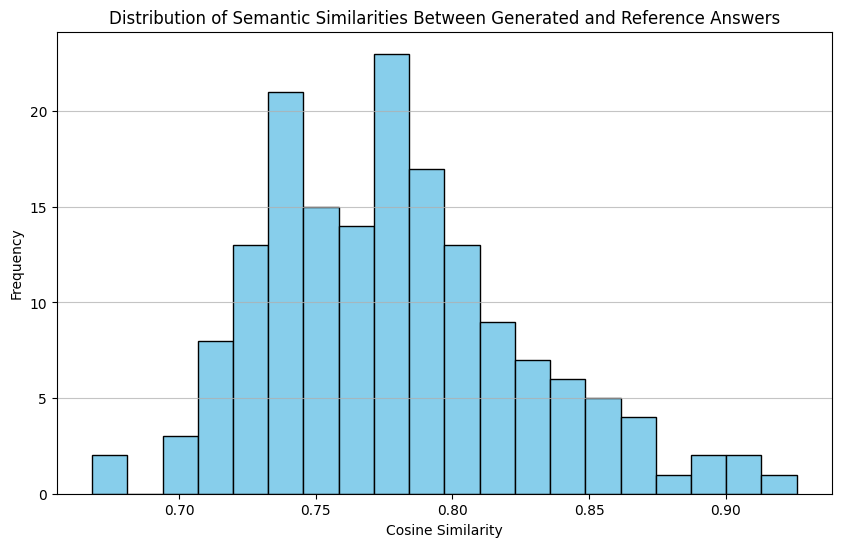

,index,similarity
11,30,0.925892
121,181,0.905980
126,186,0.905905
148,221,0.892190
23,46,0.888877
32,59,0.880766
156,232,0.874245
43,73,0.864804
36,65,0.863038
143,215,0.862223


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# We'll need to convert the text to embeddings using Mistral's embedding model
# First, let's create a function to get embeddings
def get_embedding(text):
    try:
        embedding = client.embeddings.create(
            model="mistral-embed",
            inputs=[text],
        ).data[0].embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

# Create a function to calculate cosine similarity using embeddings
def calculate_similarity(text1, text2):
    emb1 = get_embedding(text1)
    emb2 = get_embedding(text2)
    
    if emb1 is None or emb2 is None:
        return None
        
    # Convert to numpy arrays and reshape for cosine_similarity
    emb1_np = np.array(emb1).reshape(1, -1)
    emb2_np = np.array(emb2).reshape(1, -1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(emb1_np, emb2_np)[0][0]
    return similarity

# Calculate similarity for each pair of answers
similarities = {}
for i, key in enumerate(cleaned_answers_keys):
    generated_answer = cleaned_answers[key]
    reference_answer = corresponding_answers.iloc[i]
    
    similarity = calculate_similarity(generated_answer, reference_answer)
    similarities[key] = similarity
    
    # Print progress every 10 items
    if i % 10 == 0:
        print(f"Processed {i}/{len(cleaned_answers_keys)} items")

# Print the results
avg_similarity = np.mean([s for s in similarities.values() if s is not None])
print(f"\nAverage similarity: {avg_similarity:.4f}")

# Create a histogram of similarities
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist([s for s in similarities.values() if s is not None], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Semantic Similarities Between Generated and Reference Answers')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Save the similarities to a DataFrame for further analysis
similarity_df = pd.DataFrame({
    'index': list(similarities.keys()),
    'similarity': list(similarities.values())
})
similarity_df = similarity_df.sort_values('similarity', ascending=False)
similarity_df.to_csv('answer_similarities.csv', index=False)

similarity_df.head(10)  # Show the top 10 most similar answers

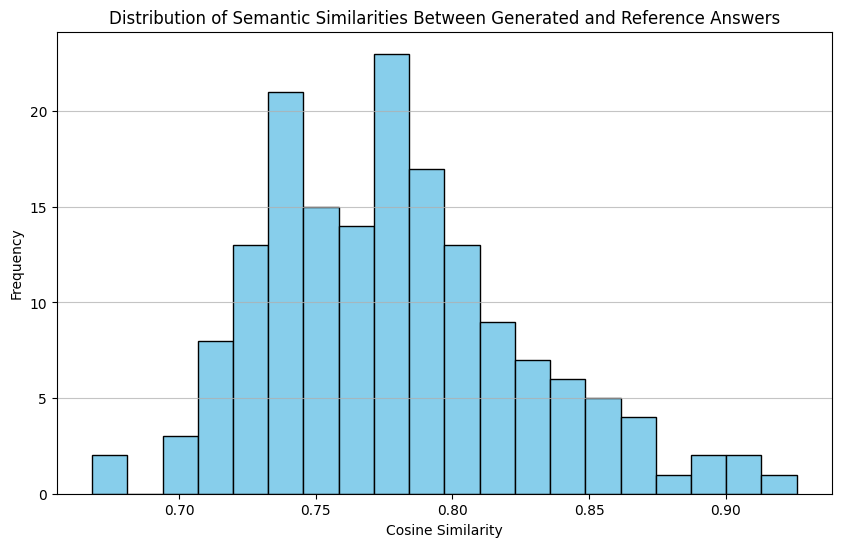

,index,similarity
11,30,0.925892
121,181,0.905980
126,186,0.905905
148,221,0.892190
23,46,0.888877
32,59,0.880766
156,232,0.874245
43,73,0.864804
36,65,0.863038
143,215,0.862223


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist([s for s in similarities.values() if s is not None], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Semantic Similarities Between Generated and Reference Answers')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

concatenated_similarity_df = pd.concat([similarity_df, similarity_df], axis=0)

# Save the similarities to a DataFrame for further analysis
concatenated_similarity_df = pd.DataFrame({
    'index': list(similarities.keys()),
    'similarity': list(similarities.values())
})
concatenated_similarity_df = concatenated_similarity_df.sort_values('similarity', ascending=False)
concatenated_similarity_df.to_csv('answer_similarities_concat.csv', index=False)

concatenated_similarity_df.head(10)  # Show the top 10 most similar answers

In [97]:
concatenated_similarity_df.mean()

index         126.289157
similarity      0.778714
dtype: float64